---
# **TP3: Introduction to graph ML : predict nodes inside graph network**
---

## Imports

In [12]:
!pip install neo4j pandas seaborn matplotlib scikit-learn

## Reconnect from Python

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

url = "bolt://localhost:7687"
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(url, auth=(username, password))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        try:
            return result.to_df()
        except AttributeError:
            # fallback if to_df not available
            return pd.DataFrame([r.data() for r in result])

run_query("SHOW DATABASES")

,name,type,aliases,access,address,role,writer,requestedStatus,currentStatus,statusMessage,default,home,constituents
0,neo4j,standard,[],read-write,localhost:7687,primary,True,online,online,,True,True,[]
1,system,system,[],read-write,localhost:7687,primary,True,online,online,,False,False,[]


## Load the Twitch streams (nodes)

In [3]:
# constraint on streamId
run_query("""
CREATE CONSTRAINT stream_id IF NOT EXISTS
FOR (s:Stream)
REQUIRE s.streamId IS UNIQUE
""")

# load streams
run_query("""
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3JjgKgZ' AS row
MERGE (s:Stream {streamId: toInteger(row.id)})
SET s.language = row.language
""")

# sanity-check
run_query("MATCH (s:Stream) RETURN count(s) AS n_streams")


,n_streams
0,3721


## Load the SHARED_AUDIENCE relationships

In [4]:
run_query("""
CALL {
  LOAD CSV WITH HEADERS FROM 'https://bit.ly/3S9Uyd8' AS row
  WITH row
  MATCH (s1:Stream {streamId: toInteger(row.source)})
  MATCH (s2:Stream {streamId: toInteger(row.target)})
  MERGE (s1)-[r:SHARED_AUDIENCE]->(s2)
  SET r.weight = toInteger(row.weight)
}
IN TRANSACTIONS OF 1000 ROWS
""")

# check counts
run_query("MATCH ()-[r:SHARED_AUDIENCE]->() RETURN count(r) AS n_rels")


,n_rels
0,131427


## Create the GDS graph projection

In [5]:
run_query("""
CALL gds.graph.project(
  'twitch',
  'Stream',
  {
    SHARED_AUDIENCE: {
      type: 'SHARED_AUDIENCE',
      orientation: 'UNDIRECTED',
      properties: 'weight'
    }
  }
)
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}","{'SHARED_AUDIENCE': {'aggregation': 'DEFAULT',...",twitch,3721,262854,3000


## Run node2vec and write embeddings

In [6]:
run_query("""
CALL gds.node2vec.write(
  'twitch',
  {
    embeddingDimension: 8,
    relationshipWeightProperty: 'weight',
    inOutFactor: 0.5,
    returnFactor: 1.0,
    writeProperty: 'node2vec'
  }
)
""")


,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,0,11159,227,"{'writeProperty': 'node2vec', 'walkLength': 80...",[22240311.663193118]


---
## Distances on edges: Euclidean vs Cosine
---

## Get embeddings for each edge

In [7]:
pairs = run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]-(s2:Stream)
RETURN s1.node2vec AS emb1, s2.node2vec AS emb2
""")
len(pairs)


262854

## Compute distances & plot

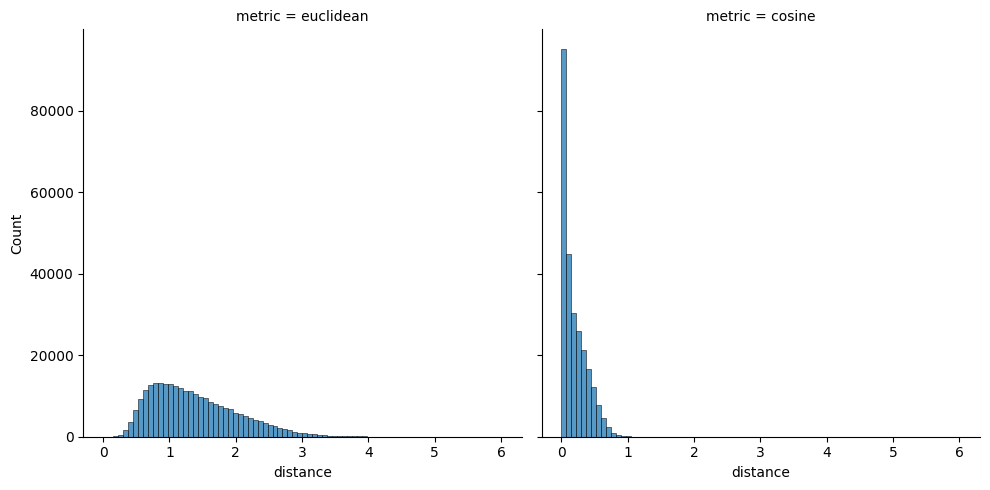

In [14]:
import numpy as np
import matplotlib as plt
import seaborn as sns
emb1 = np.array(pairs["emb1"].tolist())
emb2 = np.array(pairs["emb2"].tolist())

# Euclidean distance
diff = emb1 - emb2
eucl = np.linalg.norm(diff, axis=1)

# Cosine distance = 1 - cosine similarity
dot = (emb1 * emb2).sum(axis=1)
n1 = np.linalg.norm(emb1, axis=1)
n2 = np.linalg.norm(emb2, axis=1)
cos_sim = dot / (n1 * n2)
cos_dist = 1 - cos_sim

dist_df = pd.DataFrame({
    "distance": np.concatenate([eucl, cos_dist]),
    "metric":   ["euclidean"] * len(eucl) + ["cosine"] * len(cos_dist)
})

plt.rcParams["figure.figsize"] = [16, 6]
sns.displot(data=dist_df, x="distance", col="metric", bins=80)


---
## Degree distribution vs cosine similarity
---

<Axes: xlabel='cosineSimilarity', ylabel='avgDegree'>

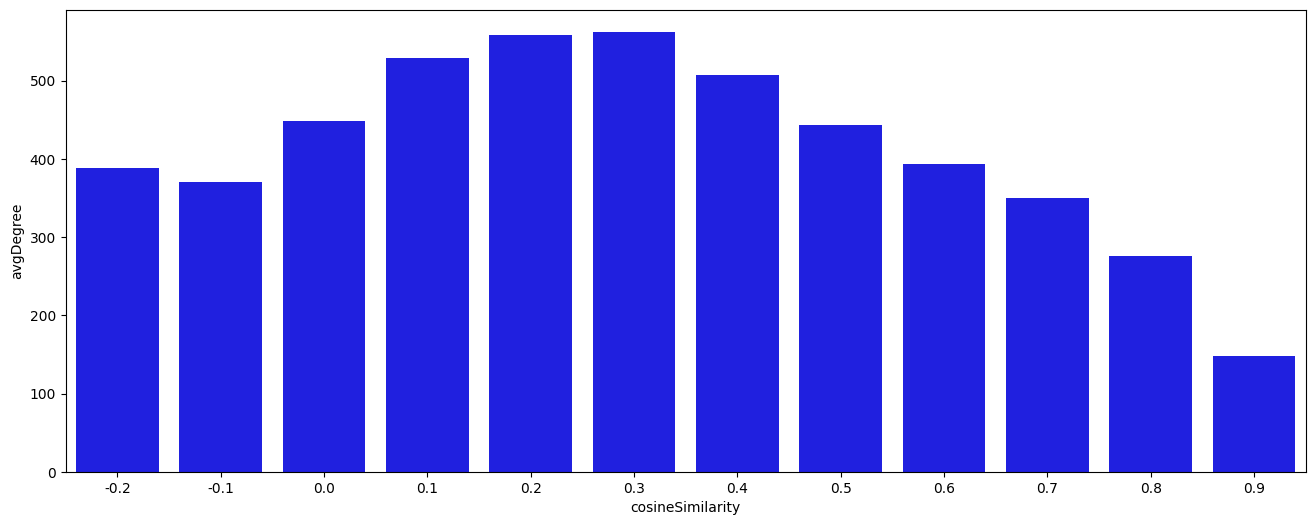

In [16]:
df_deg = run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]-(s2:Stream)
WITH s1, s2,
     gds.similarity.cosine(s1.node2vec, s2.node2vec) AS cos,
     COUNT { (s1)-[:SHARED_AUDIENCE]-() } AS degree   // degree of s1
WITH toFloat(floor(cos * 10)) / 10.0 AS cosineSimilarity,
     degree
RETURN cosineSimilarity, avg(degree) AS avgDegree
ORDER BY cosineSimilarity
""")

sns.barplot(data=df_deg, x="cosineSimilarity", y="avgDegree", color="blue")

---
## Avg edge weight vs cosine similarity
---

<Axes: xlabel='cosineSimilarity', ylabel='avgWeight'>

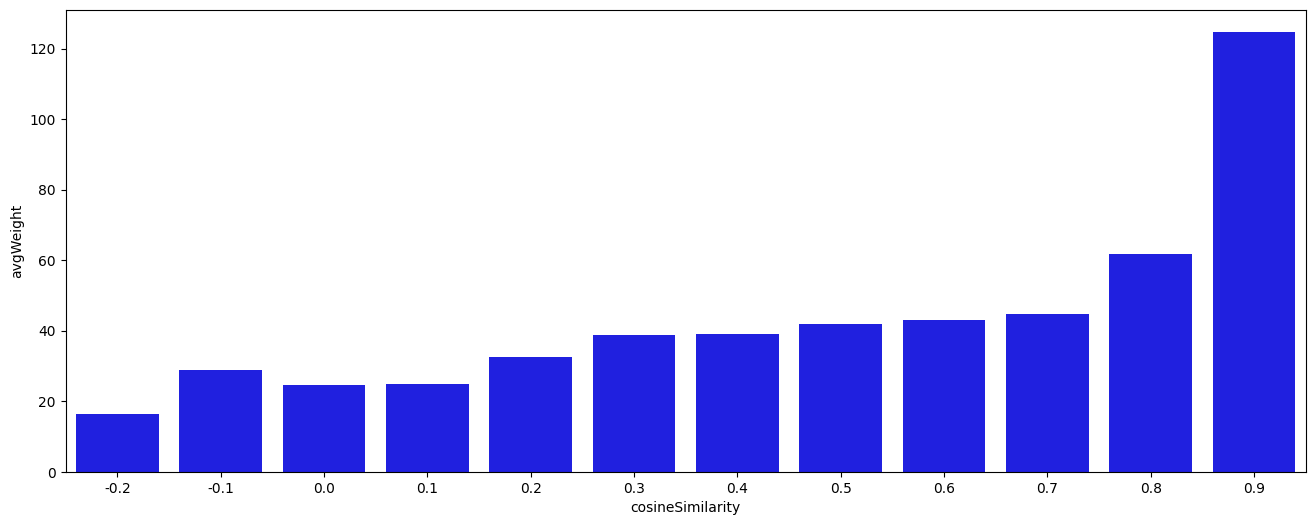

In [18]:
df_weight = run_query("""
MATCH (s1:Stream)-[r:SHARED_AUDIENCE]-(s2:Stream)
WITH r,
     gds.similarity.cosine(s1.node2vec, s2.node2vec) AS cos
WITH toFloat(floor(cos * 10)) / 10.0 AS cosineSimilarity,
     r.weight AS w
RETURN cosineSimilarity, avg(w) AS avgWeight
ORDER BY cosineSimilarity
""")

sns.barplot(data=df_weight, x="cosineSimilarity", y="avgWeight", color="blue")

---
## Get embeddings + language from Neo4j
---

In [19]:
data = run_query("""
MATCH (s:Stream)
WHERE s.language IS NOT NULL AND s.node2vec IS NOT NULL
RETURN s.streamId AS streamId,
       s.language AS language,
       s.node2vec AS embedding
""")
data.head()

,streamId,language,embedding
0,129004176,en,"[1.7062021493911743, 0.40626150369644165, -0.2..."
1,26490481,en,"[1.5810573101043701, 0.063445083796978, -0.659..."
2,213749122,en,"[1.7576481103897095, 0.5022571086883545, 0.390..."
3,30104304,en,"[1.2717127799987793, 0.1787041425704956, -0.45..."
4,160504245,en,"[1.4532901048660278, 0.5486809611320496, -0.24..."


## Encode labels

In [20]:
data["output"], lang_index = pd.factorize(data["language"])
lang_index  # just to see mapping

Index(['en', 'fr', 'ko', 'ru', 'es', 'de', 'zh-tw', 'tr', 'pt-br', 'it'], dtype='object')

---
## Train RandomForestClassifier
---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# X = matrix of embeddings, y = encoded labels
X = np.stack(data["embedding"].values)
y = data["output"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       364
           1       0.96      0.92      0.94        50
           2       1.00      0.81      0.89        52
           3       0.88      0.86      0.87        51
           4       0.91      0.98      0.94        61
           5       0.81      0.77      0.79        56
           6       0.95      1.00      0.98        21
           7       0.83      0.96      0.89        26
           8       0.80      0.92      0.85        38
           9       0.92      0.88      0.90        26

    accuracy                           0.89       745
   macro avg       0.90      0.90      0.90       745
weighted avg       0.89      0.89      0.89       745



---
## Confusion matrix heatmap
---

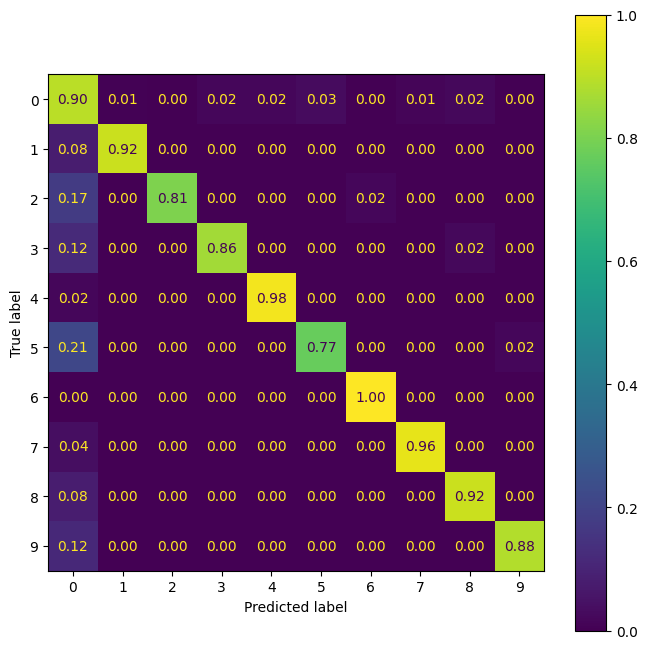

In [23]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.rcParams["figure.figsize"] = [8, 8]
disp.plot(cmap="viridis", values_format=".2f")

---
## Questions
---

### 1. **What do you think about the confusion matrix?**

The confusion matrix shows that the model performs well overall, with most predictions concentrated on the diagonal.  
However, some languages are more confused than others:

- English (0) gets slightly confused with many classes  
  → expected because English chatters join many streams.

- Languages with fewer samples (e.g., class 6 or 7) show perfect or near-perfect recall, but this is because the groups are small and well clustered.

- The main confusions happen between similar or culturally close languages, e.g.
  - French (1) ↔ English (0)
  - Portuguese-BR (8) ↔ English (0)
  - Spanish (4) shows little confusion.

Overall: no catastrophic confusion, but English remains noisy due to its global usage.

### 2. **Which metric should you show your manager and why?**

I would show macro F1-score.

Why?

- The classes are imbalanced (English has 364 samples, others have ~20–60).
- Accuracy alone would be misleading because predicting English well already boosts accuracy.
- Macro-F1 gives equal importance to all languages, which is essential for Twitch because new streams can be in minority languages too.

So: macro F1 = 0.90, which is strong and easy to communicate.

### 3. **How can you improve the classifier?**

Three realistic improvements:

**1. Use larger or richer embeddings**

- Node2Vec with `dimension = 8` is quite small.  
- Using 32 or 64 dimensions would capture more structure in the audience graph.

**2. Add more features**

Right now the model uses only the embedding + language label.  
You could add:

- degree, weight, audience size, number of shared streams  
- time-based behaviour  
- streamer metadata (followers, category)

This would reduce confusions between languages with similar neighbourhoods.

**3. Try better models**

Random Forest is good, but you could test:

- XGBoost (handles interactions well)  
- MLP (neural net) for embeddings  
- GNNs (GraphSAGE, GAT) for true graph learning  

These would likely improve performance on ambiguous languages.



